In [1]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [2]:
#!pip install pytorch_lightning
#!pip install pytorch_forecasting
#!pip install tensorflow
#!pip install tensorboard

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 582 kB 23.1 MB/s eta 0:00:01
     |████████████████████████████████| 398 kB 72.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 55.8 MB/s eta 0:00:01
     |████████████████████████████████| 158 kB 97.5 MB/s eta 0:00:01
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 127 kB 22.1 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 54.0 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 26.7 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 87.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 91.5 MB/s eta 0:00:01
     |████████████████████████████████| 210 kB 81.7 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 88.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 80.6 MB/s eta 0:00:01
     |██████████████████████

In [3]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder 
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [4]:
# Get device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
#Load the data
data = pd.read_csv("/notebooks/demand_pv_temp_forecast_timefeatures_hols_v2_nsw_month_series_clean.csv")

In [6]:
#Create test and training data (train up to Dec 2020)
test = data[data.DATETIME > '2021-01-01']
test = test[test.DATETIME < '2021-02-01']
data = data[data.DATETIME < '2021-01-01']

In [7]:
#Create testing data


In [8]:
# Drop the PV data
data.drop(['POWER', 'LOCATION', 'FORECASTDEMAND', 'SUNRISE', 'SUNSET', 'Year'], axis=1, inplace=True)
booleanDictionary = {True: 'TRUE', False: 'FALSE'}
data.replace(booleanDictionary, inplace=True)
data.sample(10, random_state=48)

,STATE,DATETIME,TOTALDEMAND,TEMPERATURE,Weekday,Quarter,Month,Season,Day,DAYTYPE,HOLIDAY,time_idx,month_idx,group
9274,NSW,2018-10-14 05:00:00,5888.21,15.2,Sunday,4,10,Spring,14,Night,FALSE,10,634,2018-10
34355,NSW,2020-03-21 17:30:00,7988.74,20.7,Saturday,1,3,Autumn,21,Day,FALSE,35,995,2020-3
38274,NSW,2020-06-11 09:00:00,9027.91,13.7,Thursday,2,6,Winter,11,Day,FALSE,18,498,2020-6
22819,NSW,2019-07-25 09:30:00,9416.76,11.4,Thursday,3,7,Winter,25,Day,FALSE,19,1171,2019-7
41891,NSW,2020-08-25 17:30:00,9897.68,12.2,Tuesday,3,8,Winter,25,Day,FALSE,35,1187,2020-8
10995,NSW,2018-11-19 01:30:00,6106.07,12.0,Monday,4,11,Spring,19,Night,FALSE,3,867,2018-11
10655,NSW,2018-11-11 23:30:00,6678.75,14.4,Sunday,4,11,Spring,11,Night,FALSE,47,527,2018-11
18076,NSW,2019-04-17 14:00:00,7818.18,24.3,Wednesday,2,4,Autumn,17,Day,FALSE,28,796,2019-4
45581,NSW,2020-11-10 14:30:00,6312.42,20.9,Tuesday,4,11,Spring,10,Day,FALSE,29,461,2020-11
16459,NSW,2019-03-13 21:30:00,7955.44,21.9,Wednesday,1,3,Autumn,13,Night,FALSE,43,619,2019-3


In [9]:
# Test creating TimeSeriesDataSet
max_prediction_length = 48
max_encoder_length = 48
training_cutoff = data["month_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="month_idx",
    target="TOTALDEMAND",
    group_ids=["group"],
    min_encoder_length= max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=[],
    static_reals=[],
    time_varying_known_categoricals=["Weekday", "Season", "DAYTYPE", "HOLIDAY"],
    variable_groups={},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["Quarter", "time_idx", "Month", "Day"],
    time_varying_unknown_categoricals=["group"],
    time_varying_unknown_reals=[
        "TOTALDEMAND",
        "TEMPERATURE"
    ],
    target_normalizer=GroupNormalizer(
        groups=["group"], transformation="softplus"
    ),  # use softplus and normalize by group
    categorical_encoders={"group":NaNLabelEncoder(
        add_nan=True
    )},
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    allow_missing_timesteps=True
)

In [10]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

In [11]:
# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

Create baseline model

In [12]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

915.5519409179688

Train model

In [13]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("/notebooks/lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=200,
    gpus=1,
    #weights_summary="top",
    enable_model_summary=True,
    gradient_clip_val=0.9885651220346836,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.022719988758212892,
    hidden_size=118,
    attention_head_size=2,
    dropout=0.1894208757004314,
    hidden_continuous_size=78,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=-1,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 1198.0k


In [14]:
# fit network
import tensorflow as tf 
import tensorboard as tb 

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 459   
3  | prescalers                         | ModuleDict                      | 1.6 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 95.9 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 232 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 164 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 56.4 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 56.4 K
9  | static_context_initial_cell_lstm 

Epoch 0:  97%|█████████▋| 30/31 [00:09<00:00,  3.19it/s, loss=233, v_num=21, train_loss_step=223.0]
Validation: 0it [00:00, ?it/s]
Epoch 1:  97%|█████████▋| 30/31 [00:19<00:00,  1.56it/s, loss=178, v_num=21, train_loss_step=164.0, val_loss=240.0, train_loss_epoch=290.0]
Validation: 0it [00:00, ?it/s]
Epoch 2:  97%|█████████▋| 30/31 [00:29<00:00,  1.01it/s, loss=142, v_num=21, train_loss_step=172.0, val_loss=182.0, train_loss_epoch=184.0]
Validation: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████▋| 30/31 [00:42<00:01,  1.41s/it, loss=134, v_num=21, train_loss_step=138.0, val_loss=134.0, train_loss_epoch=148.0]
Validation: 0it [00:00, ?it/s]
Epoch 4:  97%|█████████▋| 30/31 [00:54<00:01,  1.82s/it, loss=111, v_num=21, train_loss_step=107.0, val_loss=114.0, train_loss_epoch=135.0]
Validation: 0it [00:00, ?it/s]
Epoch 5:  97%|█████████▋| 30/31 [01:06<00:02,  2.21s/it, loss=103, v_num=21, train_loss_step=113.0, val_loss=99.80, train_loss_epoch=112.0]
Validation: 0it [00:00, ?it/s]
Epoch 6:  97%|

In [15]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

In [16]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
#(actuals - predictions).abs().mean()
(actuals - predictions).abs().mean().item()

28.320261001586914

In [17]:
#RMSE for validation set
rmse = mean_squared_error(actuals, predictions, squared=False)
rmse


36.58713

In [18]:
# MAPE for validation set
mape = mean_absolute_percentage_error(actuals, predictions)
mape

0.0035321077

In [19]:
# Write output to file
f = open("/notebooks/log-tft-no-pv.log", "a")
f.write('TFT - NO PV ' + '\n\n\n')
f.write('RMSE - ' + str(rmse) + '\n')
f.write('MAPE - ' + str(mape) + '\n')
f.close()

In [20]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

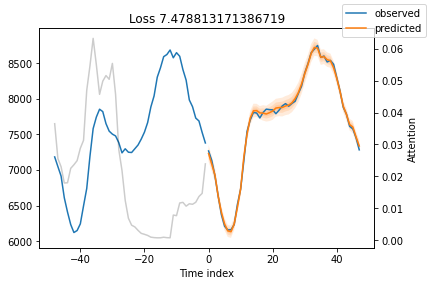

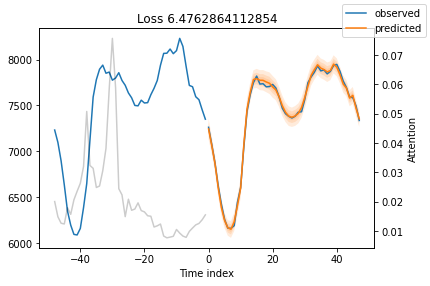

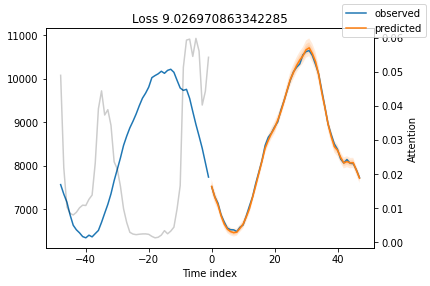

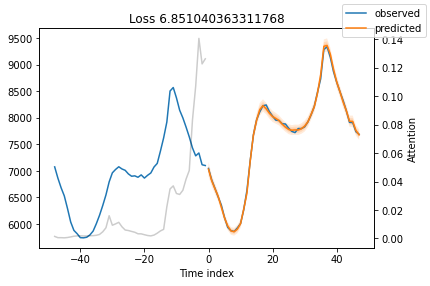

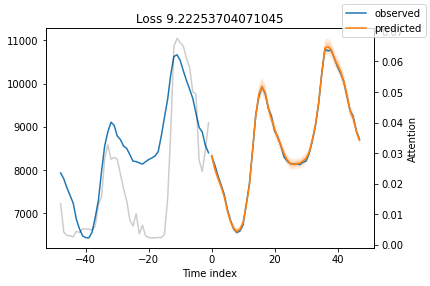

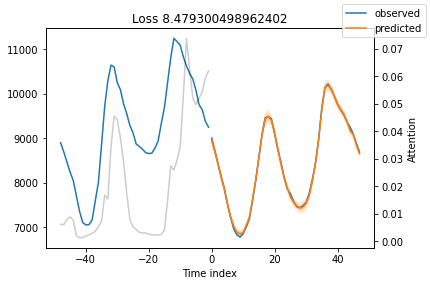

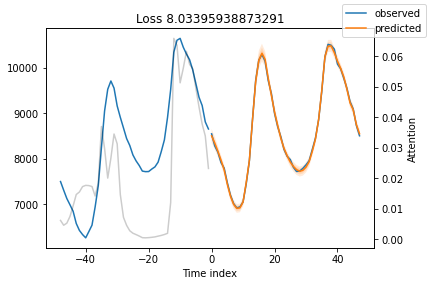

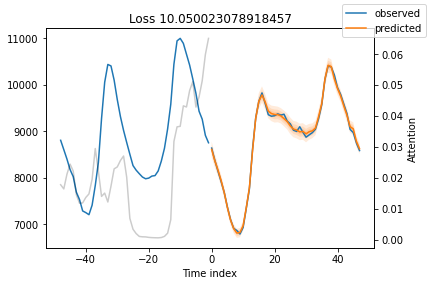

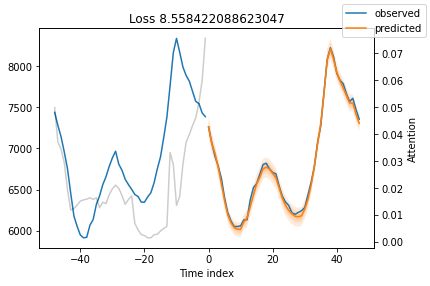

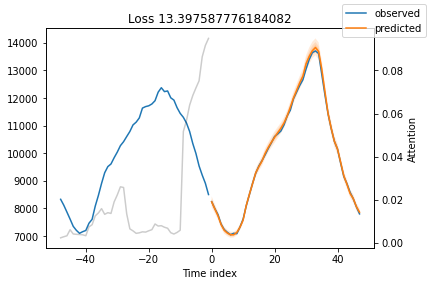

In [21]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

Predict new data

In [22]:
Jan2021 = pd.read_csv("/notebooks/Jan2021_predicton_dataset.csv")
Jan2021.drop(["POWER"], axis=1, inplace=True)
booleanDictionary = {True: 'TRUE', False: 'FALSE'}
Jan2021.replace(booleanDictionary, inplace=True)
Jan2021.sample(10, random_state=48)
Jan2021

,STATE,DATETIME,TOTALDEMAND,LOCATION,TEMPERATURE,FORECASTDEMAND,Weekday,Quarter,Month,Season,Day,Year,SUNRISE,SUNSET,DAYTYPE,HOLIDAY,time_idx,month_idx,group
0,NSW,2020-12-02 00:00:00,7561.76,Bankstown,22.0,7790.651127,Wednesday,4,12,Summer,2,2020,2020-12-02 04:38:00,2020-12-02 18:53:00,Night,FALSE,0,0,Jan1
1,NSW,2020-12-02 00:30:00,7305.28,Bankstown,21.8,7561.755000,Wednesday,4,12,Summer,2,2020,2020-12-02 04:38:00,2020-12-02 18:53:00,Night,FALSE,1,1,Jan1
2,NSW,2020-12-02 01:00:00,7058.13,Bankstown,21.9,7285.742603,Wednesday,4,12,Summer,2,2020,2020-12-02 04:38:00,2020-12-02 18:53:00,Night,FALSE,2,2,Jan1
3,NSW,2020-12-02 01:30:00,6806.22,Bankstown,21.8,6942.422162,Wednesday,4,12,Summer,2,2020,2020-12-02 04:38:00,2020-12-02 18:53:00,Night,FALSE,3,3,Jan1
4,NSW,2020-12-02 02:00:00,6596.69,Bankstown,20.1,6730.975067,Wednesday,4,12,Summer,2,2020,2020-12-02 04:38:00,2020-12-02 18:53:00,Night,FALSE,4,4,Jan1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46123,NSW,2021-01-31 21:30:00,7447.90,Bankstown,21.7,7565.679697,Sunday,1,1,Summer,31,2021,2021-01-31 05:16:00,2021-01-31 19:02:00,Night,FALSE,43,1483,Jan31
46124,NSW,2021-01-31 22:00:00,7307.91,Bankstown,21.7,7420.010000,Sunday,1,1,Summer,31,2021,2021-01-31 05:16:00,2021-01-31 19:02:00,Night,FALSE,44,1484,Jan31
46125,NSW,2021-01-31 22:30:00,7264.89,Bankstown,21.6,7288.271471,Sunday,1,1,Summer,31,2021,2021-01-31 05:16:00,2021-01-31 19:02:00,Night,FALSE,45,1485,Jan31
46126,NSW,2021-01-31 23:00:00,7095.82,Bankstown,21.6,7109.042174,Sunday,1,1,Summer,31,2021,2021-01-31 05:16:00,2021-01-31 19:02:00,Night,FALSE,46,1486,Jan31


In [23]:
# Get predictions and actuals

predictions = best_tft.predict(Jan2021)
actuals = test['TOTALDEMAND'].to_numpy()


In [24]:
#RMSE
rmse = mean_squared_error(actuals, predictions.reshape(-1), squared=False)
rmse

1552.763768146369

In [25]:
# MAPE
mape = mean_absolute_percentage_error(actuals, predictions.reshape(-1))
mape

0.1412228363099541

In [26]:
# Save test data
test['TFT'] = predictions.reshape(-1)
test.to_csv("/notebooks/Jan2021_no_pv_predictions.csv", index=False)

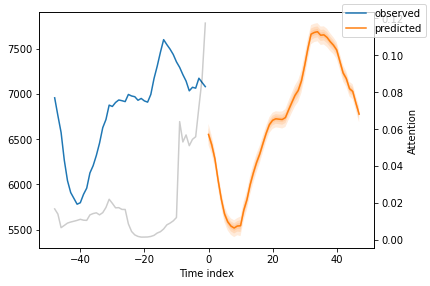

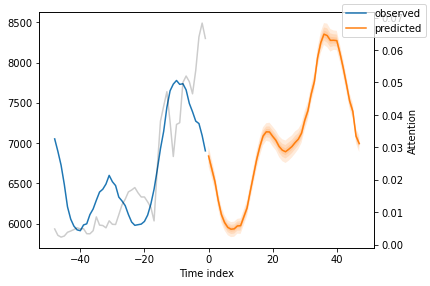

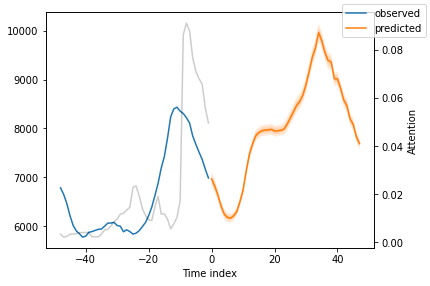

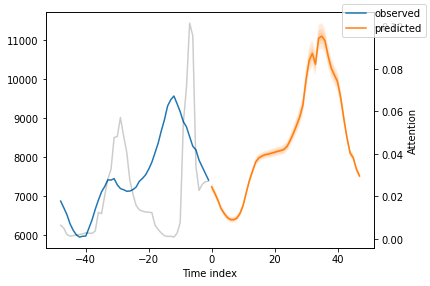

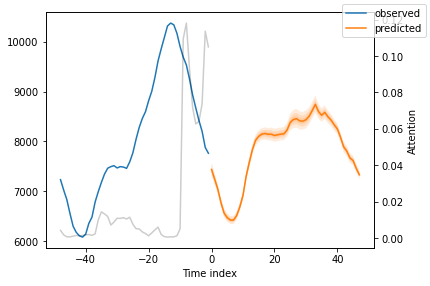

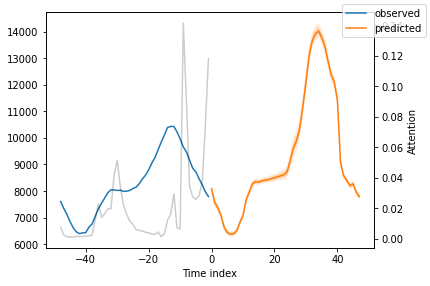

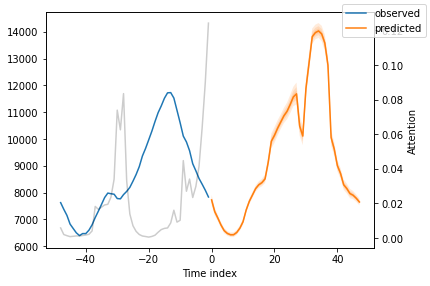

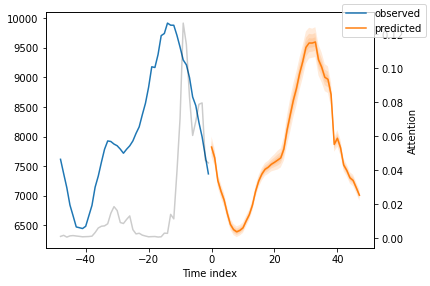

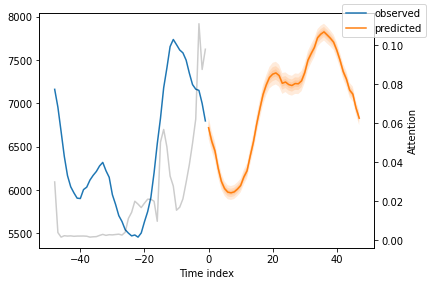

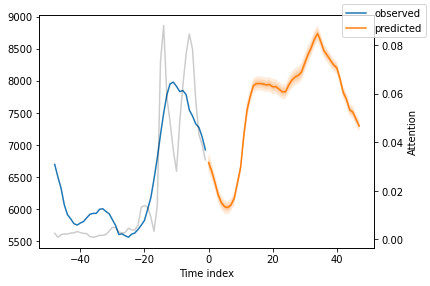

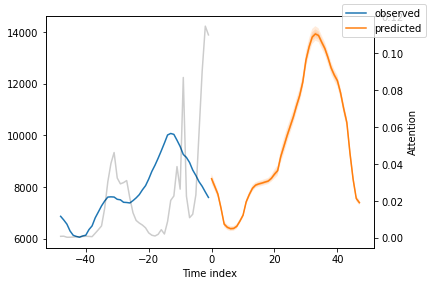

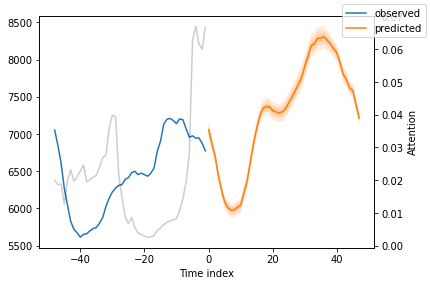

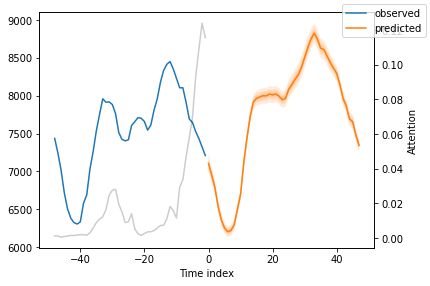

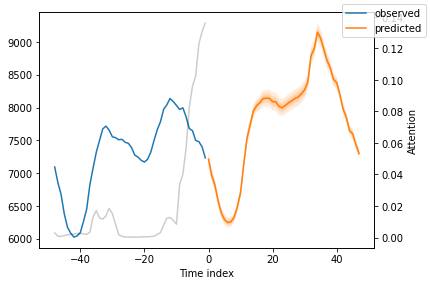

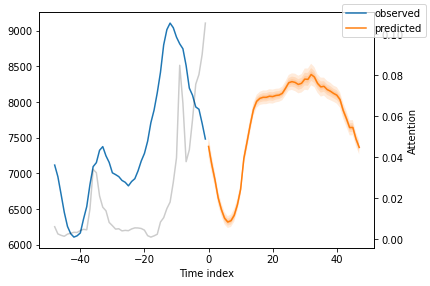

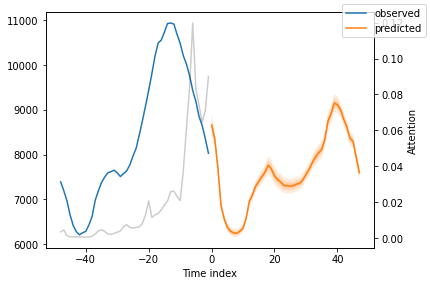

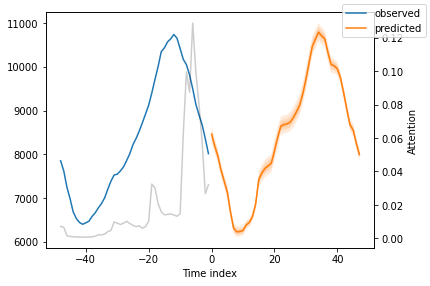

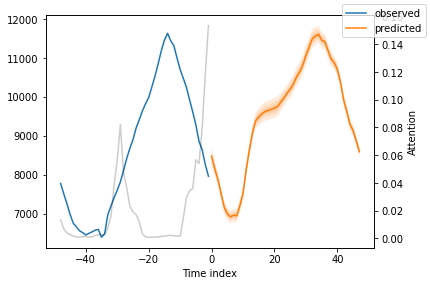

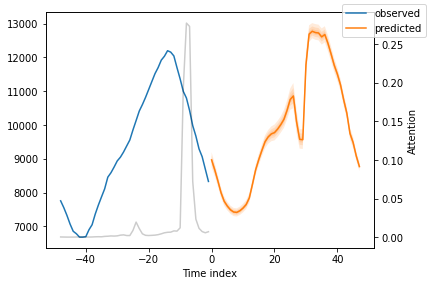

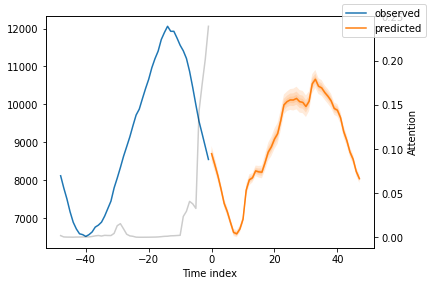

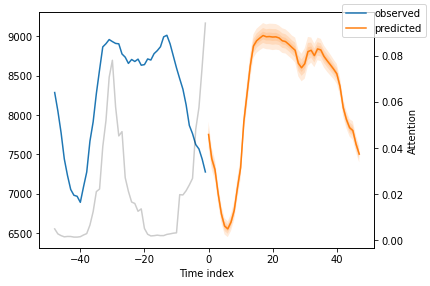

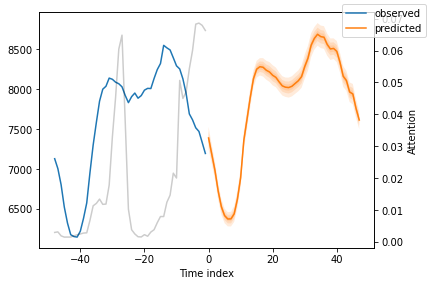

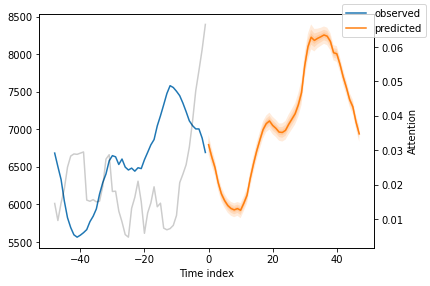

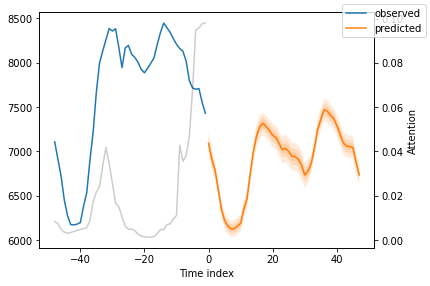

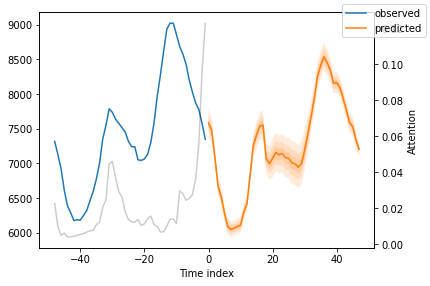

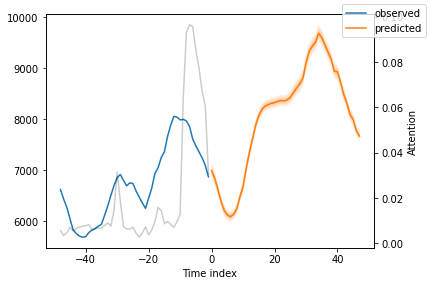

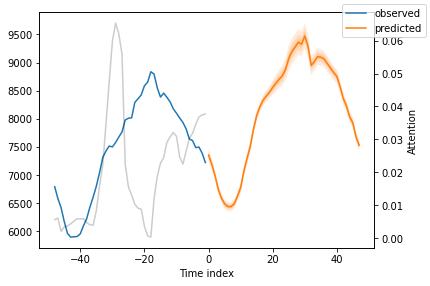

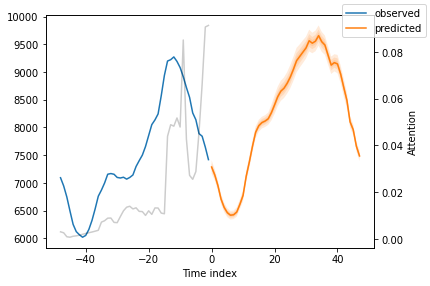

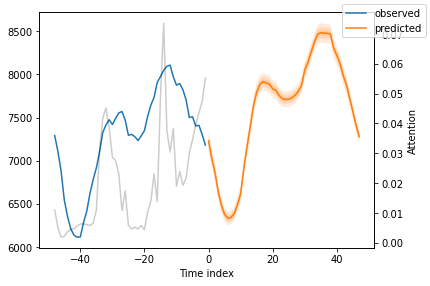

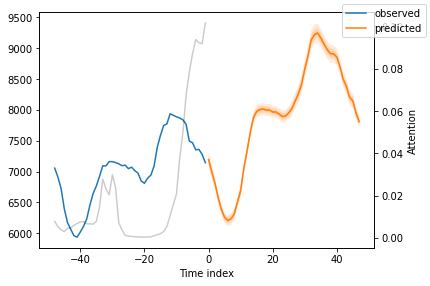

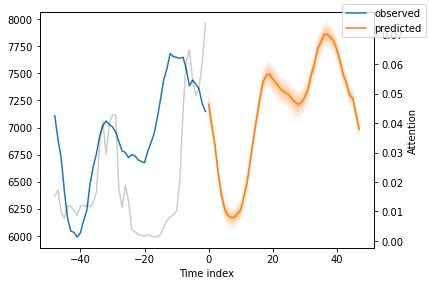

In [27]:
new_raw_predictions, new_x = best_tft.predict(Jan2021, mode="raw", return_x=True)
for idx in range(predictions.shape[0]):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);